In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/chest_xray_offline/

/content/drive/MyDrive/chest_xray_offline


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import math
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [ ]:
# Import the datasets
train_path='/content/drive/MyDrive/chest_xray_offline/train'
val_path='/content/drive/MyDrive/chest_xray_offline/test'
test_path='/content/drive/MyDrive/chest_xray_offline/val'

#  Variables
img_height=224
img_width=224
epochs=50
batch_size=16

In [ ]:
data_gen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_dataset=data_gen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode='binary',
    shuffle=True,
    # seed=42
)
val_dataset=data_gen.flow_from_directory(
    val_path,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode='binary',
    shuffle=False
    # seed=42
)
batch_images, batch_labels = train_dataset.next()
class_names = {0: 'Normal', 1: 'Pneumonia'}

Found 5216 images belonging to 2 classes.
Found 634 images belonging to 2 classes.


In [ ]:
class_indices=train_dataset.class_indices
class_names = {v: k for k, v in class_indices.items()}
# Get the total number of images for each class
total_images_per_class = {}
for class_index, class_name in class_names.items():
    class_path = os.path.join(train_path, class_name)
    total_images = len(os.listdir(class_path))
    total_images_per_class[class_name] = total_images

# Print the results
print("Total number of images per class:")
for class_name, total_images in total_images_per_class.items():
    print(f"{class_name}: {total_images} images")



Total number of images per class:
NORMAL: 1341 images
PNEUMONIA: 3875 images


In [ ]:
type(train_dataset)
type(val_dataset)

keras.src.preprocessing.image.DirectoryIterator

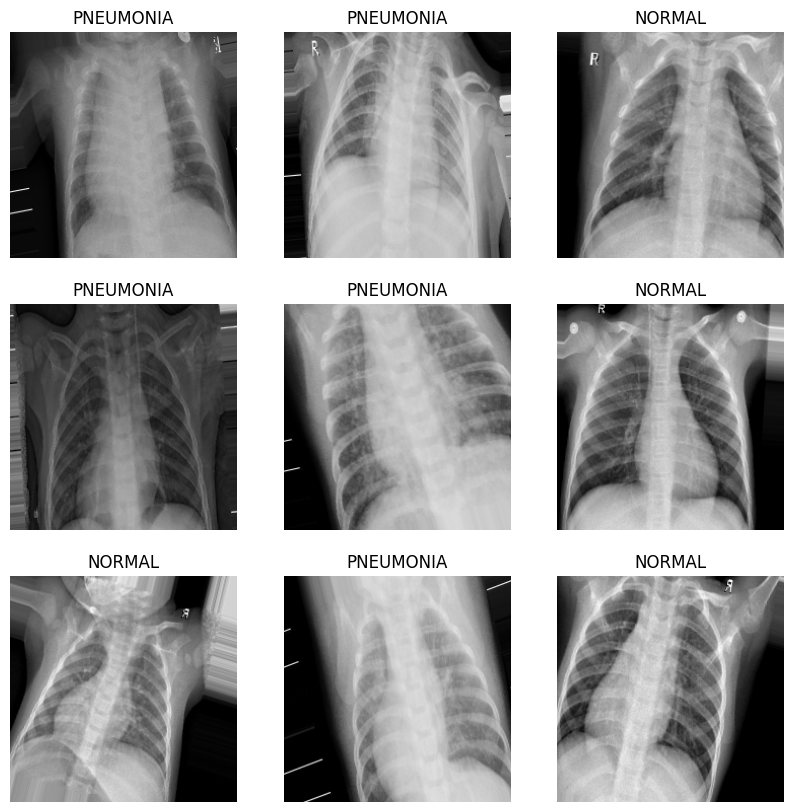

In [ ]:
# Train data visualization
plt.figure(figsize=(10, 10))
for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(batch_images[i])
      plt.title(class_names[int(batch_labels[i])])
      plt.axis("off")

In [ ]:
# Model VGG16
base_model=keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_width,img_height,3),
)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# mobile net v2
# model_mobnet_v2=keras.applications.MobileNetV2(input_shape=(img_width,img_height,3),include_top=False,weights='imagenet')
# print(model_mobnet_v2.summary())

In [ ]:
# Freezing and trainable layers of the model

base_model.trainable=True

# defining the layer position to start fine tuning
fine_tune_at=4

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [ ]:
# building the model

inputs=keras.Input((img_width,img_height,3))

base_model=base_model(inputs,training=False)

avg_pool=keras.layers.GlobalAveragePooling2D()(base_model)

batch_norm = keras.layers.BatchNormalization()(avg_pool)

layer=keras.layers.Dense(units=256,activation='relu')(batch_norm)

dropout_layer=keras.layers.Dropout(0.2)(layer)

batch_norm = keras.layers.BatchNormalization()(dropout_layer)

# layer=keras.layers.Dense(units=128,activation='relu')(batch_norm)

# dropout_layer=keras.layers.Dropout(0.2)(layer)

outputs=keras.layers.Dense(1,activation='sigmoid')(batch_norm)

model=keras.Model(inputs,outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss="binary_crossentropy",metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

In [ ]:
es=keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=8,
    verbose=1,
    mode='max',
    restore_best_weights=True
)
rp=keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    factor=0.2,
    min_lr=0.00001,
    verbose=1,
    patience=3,
    mode='max'
)

# validation_steps = len(val_dataset) // batch_size
# steps_per_epoch = len(train_dataset) // batch_size
# print(validation_steps,steps_per_epoch)

In [ ]:
# training the model
model.fit(train_dataset,batch_size=batch_size,epochs=epochs,validation_data=val_dataset,callbacks=[es,rp])

Epoch 1/50
326/326 [==============================] - 160s 474ms/step - loss: 0.3523 - accuracy: 0.8468 - val_loss: 32.9416 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 2/50
326/326 [==============================] - 154s 471ms/step - loss: 0.2959 - accuracy: 0.8664 - val_loss: 2.4773 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 3/50
326/326 [==============================] - 154s 473ms/step - loss: 0.2752 - accuracy: 0.8744 - val_loss: 6.9179 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 4/50
326/326 [==============================] - 153s 469ms/step - loss: 0.2718 - accuracy: 0.8811 - val_loss: 10.1491 - val_accuracy: 0.6309 - lr: 0.0010
Epoch 5/50
326/326 [==============================] - 152s 465ms/step - loss: 0.2654 - accuracy: 0.8804 - val_loss: 0.9184 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 6/50
326/326 [==============================] - 150s 461ms/step - loss: 0.2641 - accuracy: 0.8850 - val_loss: 8.0025 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 7/50
326/326 [========================

In [3]:
# model_path = os.path.join("model", "model.h5")
# model.save('model.h5')

In [ ]:

# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

{}


In [ ]:
# model.evaluate()

test_data=data_gen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode='binary',
)
model.evaluate(test_data)

Found 16 images belonging to 2 classes.
1/1 [==============================] - 0s 439ms/step - loss: 0.2813 - accuracy: 0.9375


[0.28128910064697266, 0.9375]

Found 624 images belonging to 2 classes.
39/39 [==============================] - 139s 4s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1
 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1
 1 0 

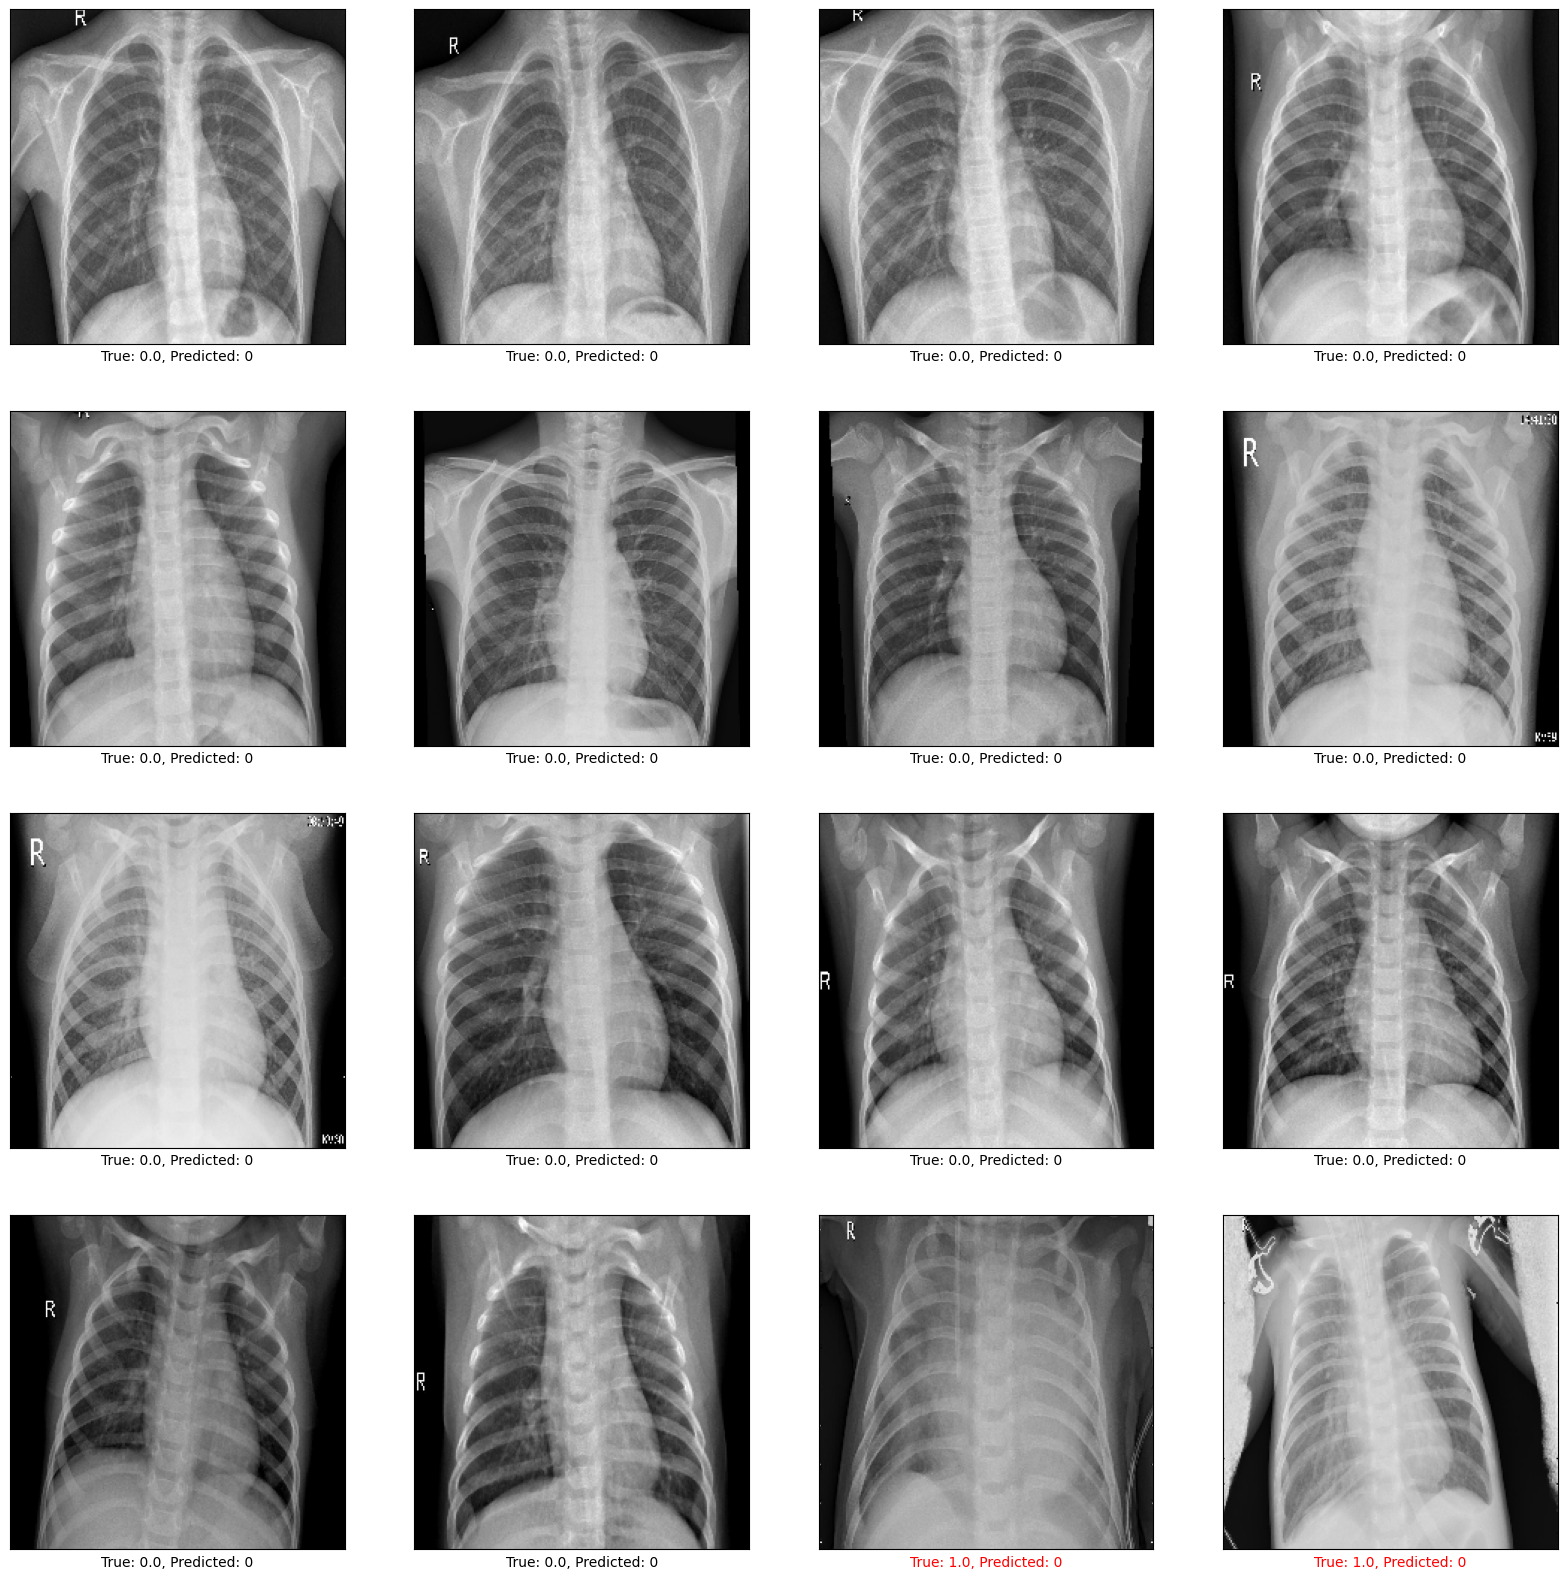

In [ ]:
testdataset=ImageDataGenerator(
    rescale=1/255.0
)
test_generator = testdataset.flow_from_directory(
    '/content/drive/MyDrive/chest_xray_offline/chest_xray/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

model =keras.models.load_model("/content/drive/MyDrive/chest_xray_offline/files/model.h5")
# Predict on the test data
predictions = model.predict(test_generator)


# Extract true labels from the test generator
true_labels = test_generator.classes

# Convert predictions to binary labels (0 or 1)
binary_predictions = np.round(predictions).flatten().astype(int)
print(binary_predictions)

# Evaluate accuracy
accuracy = np.mean(binary_predictions == true_labels)
print("Accuracy:", accuracy)


plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)

    # Get the image and label at the current index
    image, label = test_generator.next()

    # Display the image in color
    plt.imshow(image[i])  # assuming the images are in the first channel of the batch

    # Set label
    plt.xlabel(f'True: {label[i]}, Predicted: {binary_predictions[i]}',
               color='red' if label[i] != binary_predictions[i] else 'black')

    # Hide axis ticks
    plt.xticks([])
    plt.yticks([])

    # # Hide grid
    plt.grid(False)

plt.show()


In [ ]:
import cv2

testpath='/content/drive/MyDrive/chest_xray_offline/chest_xray/test/PNEUMONIA/person95_bacteria_463.jpeg'
testimage=cv2.imread(testpath)

testimage=cv2.cvtColor(testimage,cv2.COLOR_BGR2RGB)

testimage=cv2.resize(testimage,(224,224))

testimage=testimage/255.0

testimage=testimage.reshape(-1,testimage.shape[0],testimage.shape[1],testimage.shape[2])

x=model.predict(testimage)
x = np.squeeze(x, axis=0)
print(x)
x = 1 if x>.7 else 0

print(x)

1/1 [==============================] - 0s 212ms/step
[0.8274269]
1
